# Calibrating assays

This notebook gives an example how to use the `qpcr.Calibrator` to calibrate qPCR assays through either computing new primer efficiencies directly from the data, or, through using a set of externally computed efficiencies.

#### Experimental background

The datasets used for this tutorial are artificial datasets for demonstration purposes only. 

In [8]:
# import the qpcr module
import qpcr
import qpcr.Plotters as Plotters

## 1 - Data for Calibration
---
The `qpcr.Calibrator` which handles computing qPCR primer efficiencies supports three (or, rather two) modes of operation. It can either compute new efficiencies through linear regression or assign externally computed efficiencies to `qpcr.Assay` objects. The _de novo_ computation supports two sub-methods, it may either use an entire assay's dataset for computation, or only a decorated subset thereof. This allows to either run a dilution series as a separate assay or as part of a bigger assay combining calibrator replicates and replicates-of-interested in one go. Here, we shall introduce all three methods. 

### 1.1 Using an all-calibrator assay
If we ran a dilution series for an assay as a separate qPCR run, we would have a separate dataset for this. We read a regular or irregular datafile normally through the `qpcr.DataReader` to get our `qpcr.Assay` object. 

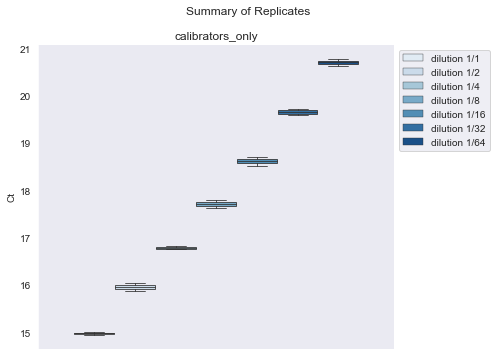

In [9]:
# a dataset containing only calibrator replicates from a dilution series
file = "./Example Data/Calibration/calibrators_only.csv"

# set up the reader
reader = qpcr.DataReader()

# read the data
calibrators_only = reader.read( file )

# and inspect the assay (don't mind the show = False)
fig = calibrators_only.boxplot( mode = "static", show = False )

### 1.2 Using a full assay with both calibrator replicates and replicates-of-interest

If we ran a dilution series and included these replicates in a single run with other replicates of interest, we can work with this the same way. However, we need to `decorate` the calibrator replicates so that the `qpcr.Calibrator` is able to distinguish between the calibration subset and the actual data-of-interest. The decoration scheme is as follows: `calibrator : some_name` which must be provided in the replicate identifier column. 

Optionally, a third part may be added as `calibrator : some_name : dilution` where the dilution is the inverted numeric dilutions step (e.g. `2` for a `1/2` dilution or `16` for a `1/16` and so on). 
Note that that the `full_assay.csv` file we load below actually specifies the calibrators in this full scheme. We will talk later about when this is useful or even necessary. 

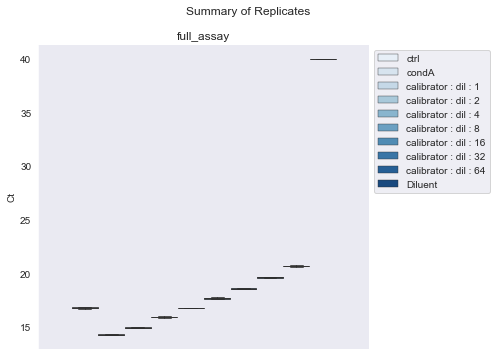

In [10]:
# a dataset containing both calibrator replicates from a dilution series 
# as well as replicates-of-interest from an experiment
file = "./Example Data/Calibration/full_assay.csv"

# read the full assay
full_assay = reader.read( file )

# and inspect as well 
fig = full_assay.boxplot( mode = "static", show = False )

## 2 - Setting up the `Calibrator`
----------------------------------------------------------------

Now the most interesting part, working with the `qpcr.Calibrator`. 
We first need to set it up, just like any of the other `qpcr` classes. 

In [11]:
# set up the calibrator
calibrator = qpcr.Calibrator()

The `Calibrator` can accept `qpcr.Assay`s and either `calibrate` them – i.e. compute new efficiencies based on the given data –, or `assign` already existing efficiencies.
Additionally, the `Calibrator` is equipped with a `pipe` method that will first attempt to assign existing efficiencies and if this was not possible attempt to compute a new efficiency from the data. 

> Note: <br> Any `calibrator` replicates are by default removed from the assay after calibration or assignment is done. This behavior can be supressed by using `remove_calibrators = False`. 

### 2.1 Newly calibrating a `qpcr.Assay`
To newly compute an efficiency from given data, we can pass the Assay to the Calibrator using `calibrate` directly. In fact, both `calibrate` and `assign` both accept `qpcr.Assay` objects directly and the `Calibrator` does not have a `link` method. 

In [12]:
# compute a new efficiency for our full assay
calibrator.calibrate( full_assay )

# now check the effiency
full_assay.efficiency()

1.087

Hence, an effiency of `1.087` was computed for the full assay. It is also noteworthy that now the dataframe of the assay is cropped to only non-calibrator replicates, so we can directly continue with our analysis using the assay.

In [13]:
full_assay.get()

,id,Ct,group,group_name
0,ctrl,16.74,0,ctrl
1,ctrl,16.91,0,ctrl
2,condA,14.36,1,condA
3,condA,14.29,1,condA
18,Diluent,40.00,9,Diluent


### 2.2 Manually specifying the `dilution`
You may wonder why we used the full-assay instead of the calibrators-only. This is because the the `full_assay` had a fully decorated calibrator subset, so the `Calibrator` was able to infer everything needed to compute the efficiency. However, what if we have a set of calibrators that are not labelled according to the full scheme, like in the `calibrators_only`?

In [14]:
calibrators_only.get()

,id,Ct,group,group_name
0,dilution 1/1,15.02,0,dilution 1/1
1,dilution 1/1,14.95,0,dilution 1/1
2,dilution 1/2,15.89,1,dilution 1/2
3,dilution 1/2,16.05,1,dilution 1/2
4,dilution 1/4,16.76,2,dilution 1/4
5,dilution 1/4,16.83,2,dilution 1/4
6,dilution 1/8,17.81,3,dilution 1/8
7,dilution 1/8,17.64,3,dilution 1/8
8,dilution 1/16,18.53,4,dilution 1/16
9,dilution 1/16,18.71,4,dilution 1/16


Well, this dataset is still perfectly good for calibration since it only contains calibrator replicates, even if they are not decorated at all. However, since they are not decorated the `Calibrator` has no way of knowing which replicates to use for calibration and which ones to leave alone. Hence, it will use **all** replicates for calibration! Additionally, even if we had decorated the replicates, the `1/1`...`1/64` will not be readable for the `Calibrator`. Hence, we must provide one additional piece of information: the `dilution`-step. The Calibrator offers the method `dilution` to set the dilution step in a number of formats. 

In [15]:
# manually specify that the dilution
# step is always 2 --> 1, 1/2, 1/4, ...
calibrator.dilution( step = 2 )

# Note: We could also have specified 0.5 
#       here to the same effect.

# and now we can calibrate the calibrators_only as well 
calibrator.calibrate( calibrators_only )

calibrators_only.efficiency()

1.087

In fact, the `calibrators_only` assay will now not empty even though all replicates were used for calibration. This is because the `Calibrator` will only remove decorated replicates but leave any others untouched.

In [16]:
calibrators_only.get()

,id,Ct,group,group_name
0,dilution 1/1,15.02,0,dilution 1/1
1,dilution 1/1,14.95,0,dilution 1/1
2,dilution 1/2,15.89,1,dilution 1/2
3,dilution 1/2,16.05,1,dilution 1/2
4,dilution 1/4,16.76,2,dilution 1/4
5,dilution 1/4,16.83,2,dilution 1/4
6,dilution 1/8,17.81,3,dilution 1/8
7,dilution 1/8,17.64,3,dilution 1/8
8,dilution 1/16,18.53,4,dilution 1/16
9,dilution 1/16,18.71,4,dilution 1/16


If we now inspect the efficiencies stored by the Calibrator we see the two computed efficiencies for our assays, which are, of course, the same since the data was the same as well. 

In [17]:
calibrator.efficiencies()

{'full_assay': 1.087, 'calibrators_only': 1.087}

### 2.3 Decorating calibrators

If you wish to include your calibrators and other replicates in the same dataset you'll have to `decorate` them in order perform calibration. However, you need not necessarily follow the full scheme and also provide the dilution step. However, if you have gaps in your dilution series it may be more convenient to include the steps directly in the identifiers since you will otherwise have to enter an iterable manually to `dilution`.

> Note: <br>
> You do not necessarily need to specify anything between `calibrator:` decorator and the dilution step. Something like `calibrator :: 2` would also work totally fine.

## 3 - Working with pre-computed efficiencies
----------------------------------------------------------------

In order to include externally computed efficiencies, the `Calibrator` is able to read a two-column reference csv file, where the first column contains assay identifiers, and the second column contains the corresponding effciencies. The Calibrator can read these using the `load` method.

> Note: <br> Any identically named efficiencies will be overwritten by newly loaded ones!

<br>

> Note:<br> The reference file must be `,`-separated (not `;`-separated)!

### 3.1 Loading pre-computed efficiencies

In [18]:
# a reference file with efficiencies
eff_file = "./Example Data/Calibration/efficiencies.csv"
calibrator.load( eff_file )

# and inspect the now loaded efficiencies
# which include both computed ones and a "test" one 
# from the efficiencies.csv file
calibrator.efficiencies()

{'full_assay': 1.087, 'calibrators_only': 1.087, 'test': 1.087}

### 3.2 Assigning pre-computed efficiencies
If we have a `qpcr.Assay` for which we have already computed an efficiency we can `assign` that efficiency directly. We will read file the `no_calibrators.csv` to obtain a super-fresh dataset again, without any calibrators and then assign the previously computed efficiency to it.

In [19]:
# a datafile with only replicates-of-interest
# and no replicates
file = "./Example Data/Calibration/no_calibrators.csv"
no_calibrators = reader.read( file )

# now since the calibrator can only assign based on the 
# assay Id, we need to set it to any of the assay's that have
# an efficiency loaded in the Calibrator. We'll use "test" here:
no_calibrators.id( "test" )

'test'

In [20]:
# inspect the efficiency
e1 = no_calibrators.efficiency()
print( "Pre-calibration:  ", e1 )

# now assign the pre-computed efficiency from the calibrator
calibrator.assign( no_calibrators )

# and inspect again
e2 = no_calibrators.efficiency()
print( "Post-calibration: ", e2 )

Pre-calibration:   1.0
Post-calibration:  1.087


### 3.3 Saving computed efficiencies
If we have computed efficiencies we will want to save them for later so we can re-use them time and time again. The Calibrator has a `save` method for this purpose. 

In [21]:
# save the computed efficiencies. 
calibrator.save()

# Note: Since we already loaded a 
#       a reference file, the same
#       file is set to the default
#       output-file. But any filepath
#       can be specified here.

## 4 - Visualising Calibrations
----------------------------------------------------------------

The Calibrator comes with a dedicated Plotter to visualise the regression lines. This is the `EfficiencyLines` Plotter.
To visualise the regression lines, simply `link` a `qpcr.Calibrator` to the `EfficiencyLines` plotter and call the `plot` method thereafter.

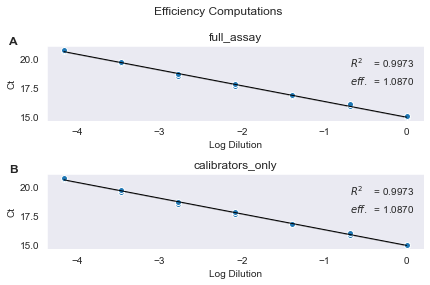

In [22]:
# set up the plotter
eff_plotter = Plotters.EfficiencyLines( mode = "static" )

# link the calibrator
eff_plotter.link( calibrator )

# and visualise
fig = eff_plotter.plot()

The same can also be achieved via the `plot` method in the `Calibrator` directly, which essentially performs the above.

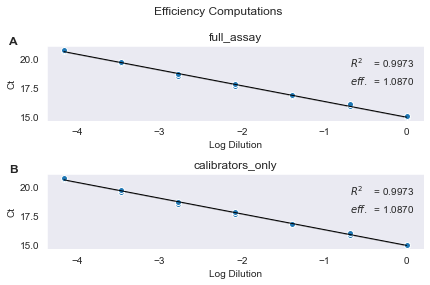

In [23]:
fig = calibrator.plot( mode = "static" )

Notice how only `full_assay` and `calibrators_only` appear in the Figure but `test` ( `no_calibrators`) does not. This is since the Calibrator did not actually compute anything there but only assigned an existing efficiency. Hence, no regression line, and thus nothing to plot here. 

Alright, with this we have reached the end of this tutorial on the `qpcr.Calibrator`, congrats! Now you are able to compute qPCR primer efficiencies using `qpcr` or include efficiencies you already computed elsewhere with your data.